In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [6]:
print('Tensorflow   :', tf.__version__)

Tensorflow   : 2.9.1


In [7]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
#GPU count and name
!nvidia-smi -L

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-3640a850-99c1-dc54-6fa7-580525d9e5af)


In [9]:
!pip freeze > requirements.txt

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Load and preprocess MNIST dataset

In [10]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)

(60000, 28, 28, 1) float32
(10000, 28, 28, 1) float32


## Draw MNIST examples

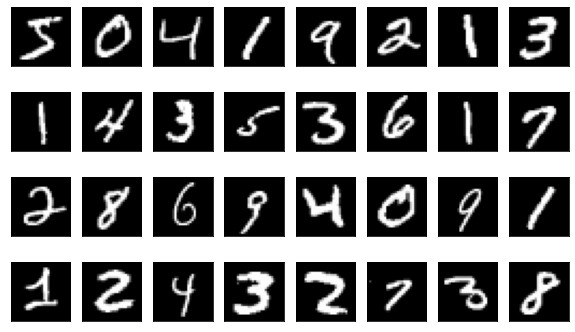

In [11]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 6))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Create Autoencoder model: Encoder and Decoder

In [12]:
train_x.shape[1:]

(28, 28, 1)

In [13]:
encoder = M.Sequential([
    #L.ZeroPadding2D((2, 2)),
    L.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=train_x.shape[1:]),
    L.MaxPooling2D((2, 2), padding='same'),
    L.Conv2D(8, (3, 3), padding='same', activation='relu'),
    L.MaxPooling2D((2, 2), padding='same'),
    L.Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'),
    # Flatten encoding for visualization
    L.Flatten(),
    L.Reshape((4, 4, 8)),
])

decoder = M.Sequential([
    L.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(4, 4, 8)),
    L.UpSampling2D((2, 2)),
    L.Conv2D(8, (3, 3), padding='same', activation='relu'),
    L.UpSampling2D((2, 2)),
    L.Conv2D(8, (3, 3), padding='same', activation='relu'),
    L.UpSampling2D((2, 2)),
    L.Conv2D(1, (3, 3), padding='same', activation='sigmoid'),
    L.Cropping2D((2, 2))
])

autoencoder = M.Sequential([encoder, decoder])

autoencoder.compile(optimizer='RMSprop', loss='mse')

In [14]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4, 4, 8)           1904      
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         1825      
                                                                 
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________


## Autoencoder training

In [15]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

In [16]:
autoencoder.fit(train_x, train_x,
                epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(test_x, test_x))

Epoch 1/25


2022-09-04 18:05:19.120935: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-04 18:05:19.121401: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


469/469 [==============================] - 5s 3ms/step - loss: 0.0490 - val_loss: 0.0331
Epoch 2/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0252
Epoch 3/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0224
Epoch 4/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0211
Epoch 5/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0175
Epoch 6/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0166
Epoch 7/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0160
Epoch 8/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0140
Epoch 9/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 10/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0150
Epoch 11/2

## Autoencoder inference test

1/1 [==============================] - 0s 102ms/step


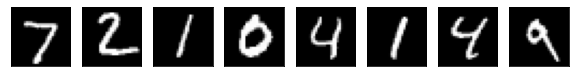

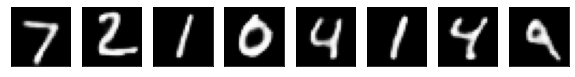

In [17]:
text_x_pred = autoencoder.predict(test_x[0:8])

plot_digits(test_x[0:8])
plot_digits(text_x_pred)

Посмотрим как происходит транформация по этапам

In [18]:
num_images = 10
random_test_images = np.random.randint(test_x.shape[0], size=num_images)

encoded_imgs = encoder.predict(test_x)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 524us/step


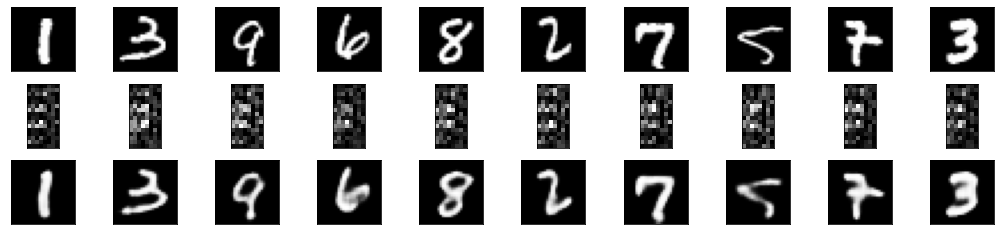

In [19]:
plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(test_x[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Decoder inference test: random inputs

1/1 [==============================] - 0s 9ms/step


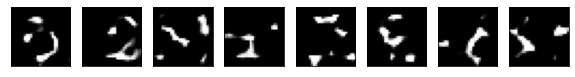

In [20]:
plot_digits(decoder.predict(np.random.rand(8, 4, 4, 8) * 5))

## Prepare noisy dataset (for Denoising AE)

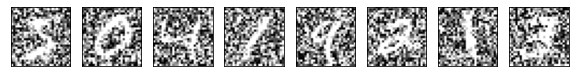

In [21]:
def add_noise(x):
    return np.clip(x + 0.5 + 0.5*np.random.randn(*x.shape), 0, 1)

train_x_noise = add_noise(train_x)
test_x_noise = add_noise(test_x)

plot_digits(train_x_noise[:8])

## Denoising Autoencoder training

In [22]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

autoencoder.fit(train_x_noise, train_x,
                epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(test_x_noise, test_x))

Epoch 1/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 0.0302
Epoch 2/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0285 - val_loss: 0.0263
Epoch 3/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0254
Epoch 4/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0241
Epoch 5/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0240
Epoch 6/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 7/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0228
Epoch 8/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0229
Epoch 9/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0216
Epoch 10/25
469/469 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0220

## Denoising Autoencoder inference test

1/1 [==============================] - 0s 10ms/step


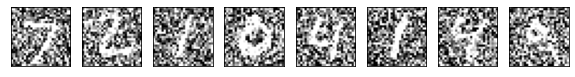

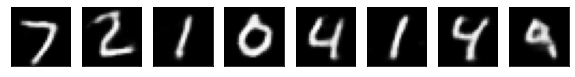

In [23]:
text_x_pred = autoencoder.predict(test_x_noise[0:8])

plot_digits(test_x_noise[0:8])
plot_digits(text_x_pred)